In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from commplax import equalizer as eq, xcomm, plot as cplt
from src import gdbp_base as gb, dataloader as dl, plot as gplt

In [2]:
data = dl.loaddata(1, 0, 4, 2)

In [3]:
z, mimo_w = eq.modulusmimo(eq.cdcomp(data.y, data.a['samplerate'], 18.451))[:2]
z, (nfo, _) = eq.framekfcpr(z, w0=data.w0)
z, phi = eq.ekfcpr(z)

# fo2 = xcomm.localfoe(z, sps=1).mean(axis=-1)

Text(0, 0.5, 'max($\\mathbf{|h|}$)')

/home/remi/Applications/miniconda3/envs/commplax_cpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


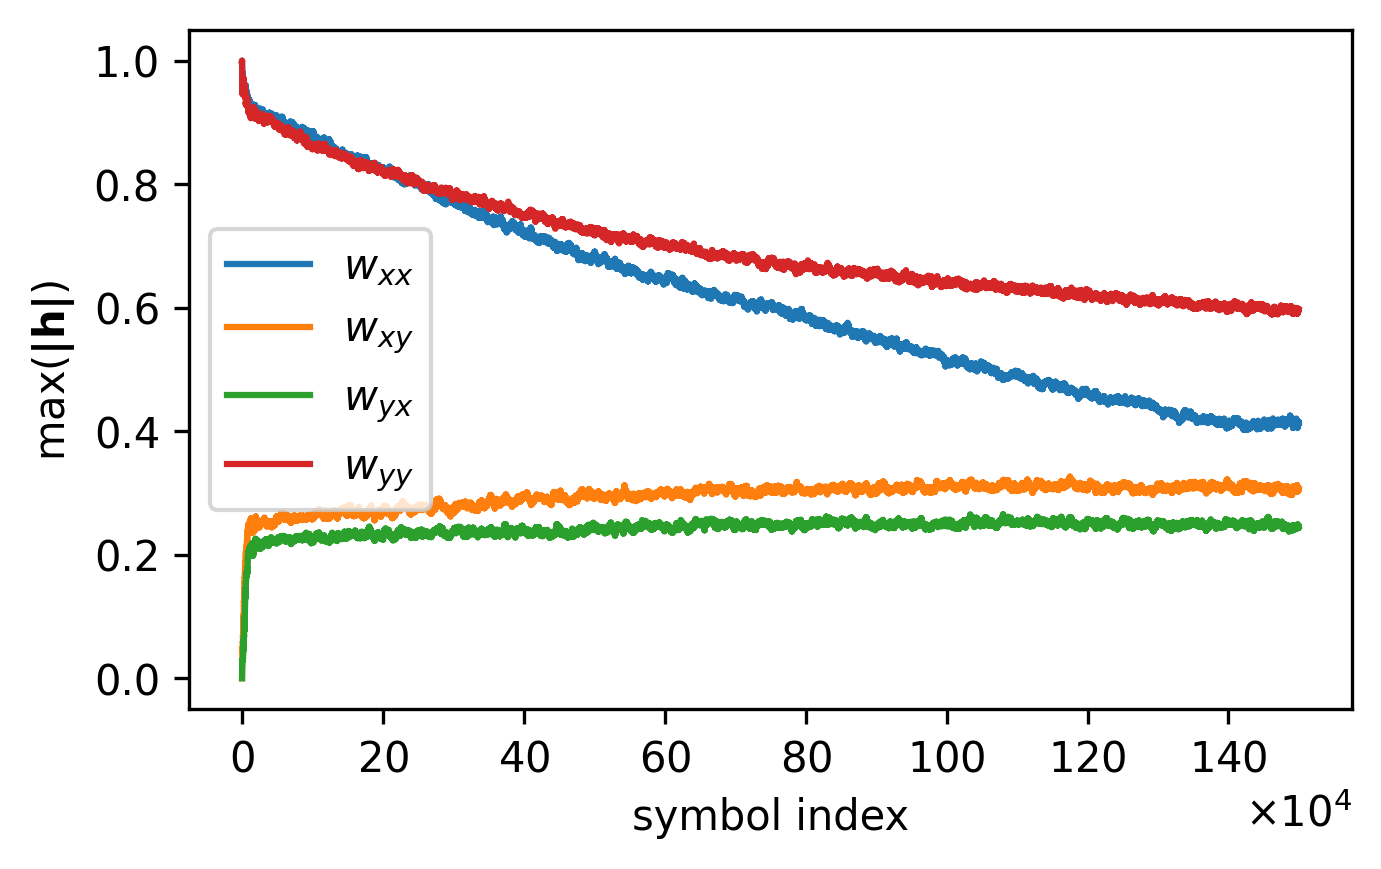

In [4]:
w_amp = np.max(np.abs(mimo_w), axis=-1)
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(w_amp[:, 0, 0], label=r'$w_{xx}$')
plt.plot(w_amp[:, 0, 1], label=r'$w_{xy}$')
plt.plot(w_amp[:, 1, 0], label=r'$w_{yx}$')
plt.plot(w_amp[:, 1, 1], label=r'$w_{yy}$')
plt.legend()

plt.ticklabel_format(axis='x', scilimits=(4, 4), useMathText=True)
plt.xlabel('symbol index')
plt.ylabel(r'max($\mathbf{|h|}$)')

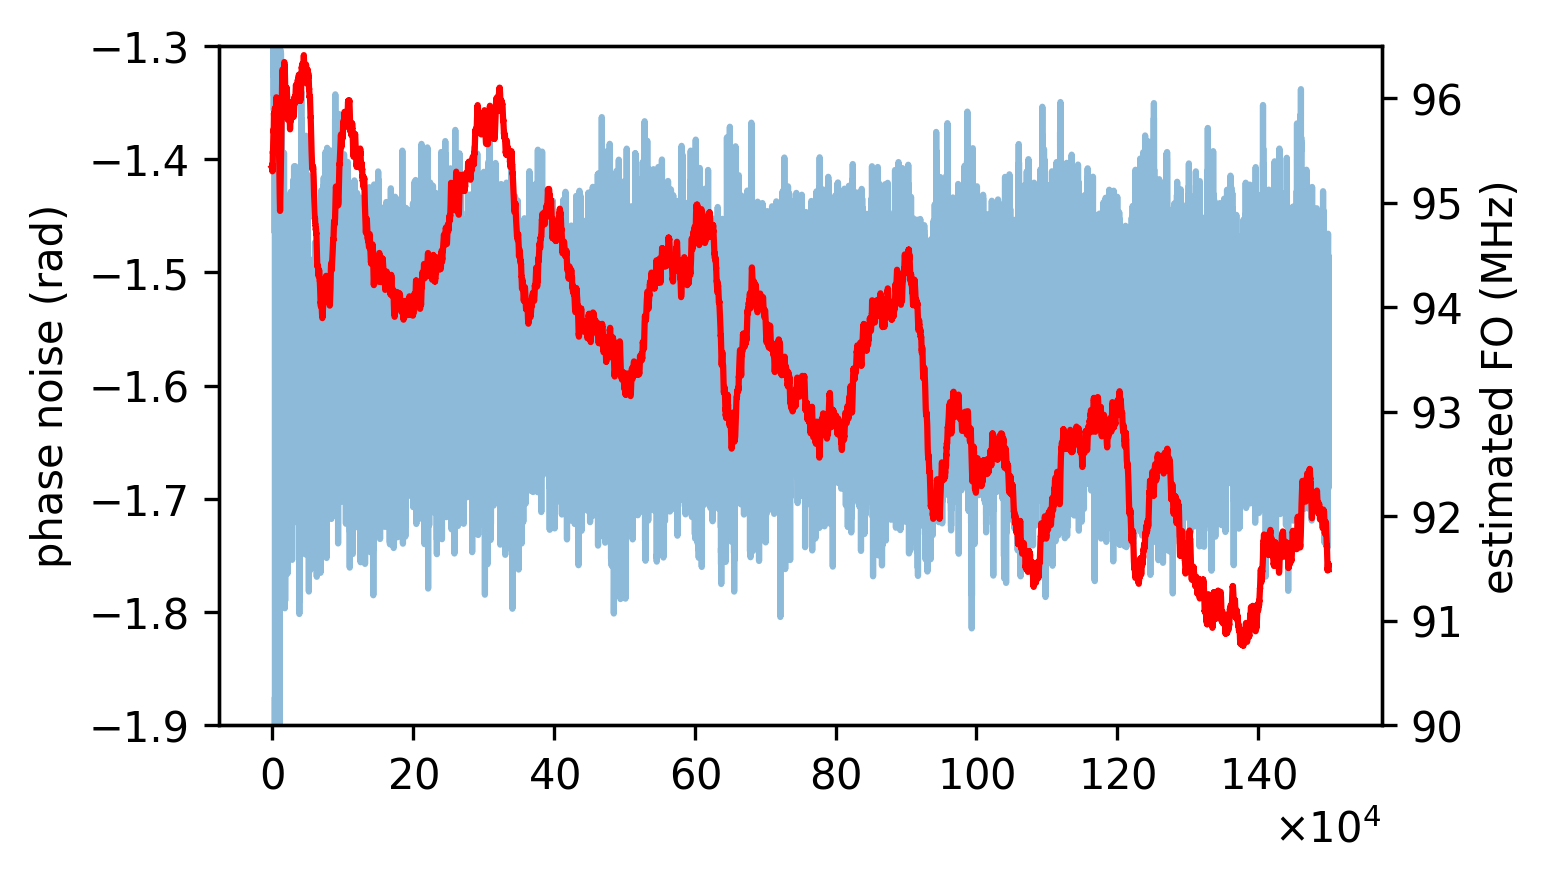

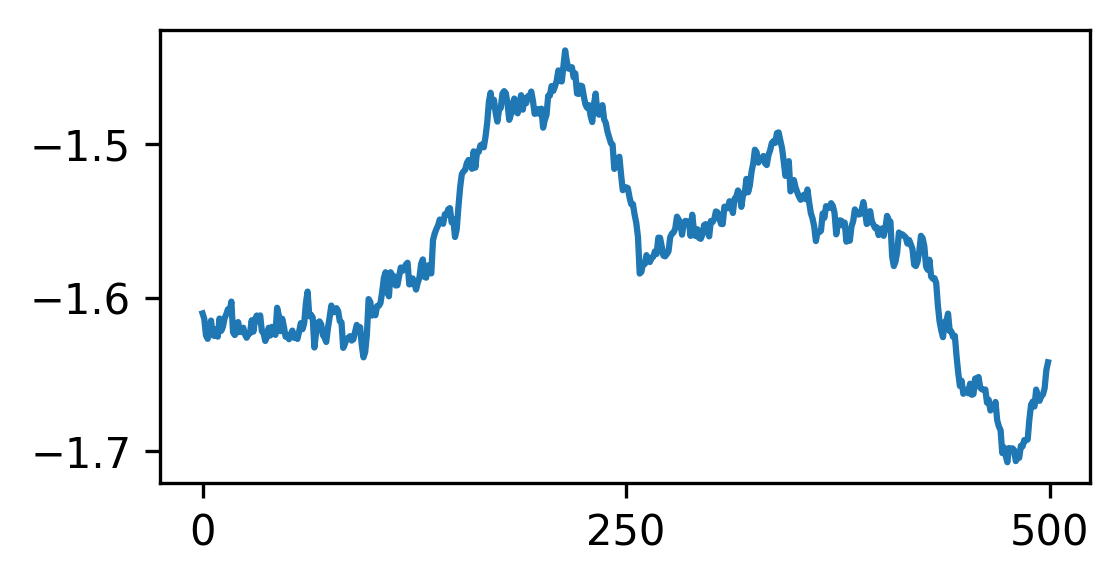

In [6]:
nfo_interp = np.interp(np.arange(z.shape[0]), np.arange(nfo.shape[0]) * 100, nfo[:, 0])
fo = nfo_interp * 36e9 / 2 / np.pi / 1e6

plt.figure(figsize=(5, 3), dpi=300)
ax1 = plt.gca()
ax1.plot(phi.real[:, 0], alpha=0.5)
ax1.set_ylim([-1.9, -1.3])
ax1.set_ylabel('phase noise (rad)')

ax2 = ax1.twinx()
ax2.plot(fo, color='red')
ax2.set_ylabel('estimated FO (MHz)')
ax2.set_xlabel('symbol index')
ax2.set_ylim([90, 96.5])

plt.ticklabel_format(axis='x', scilimits=(4, 4), useMathText=True)


plt.figure(figsize=(4, 2), dpi=300)
plt.plot(phi[200000:200500, 0].real)
locs, labels = plt.xticks()
plt.xticks([0, 250, 500])
ax = plt.gca()
ax.patch.set_alpha(0.5)

In [4]:
def train_gdbp(data, dtaps=261, ntaps=41):
  gdbp = gb.model_init(data, {'ntaps': ntaps, 'dtaps': dtaps, 'init_fn': gb.fdbp_init(data.a, xi=1.1, steps=3)}, [])
  return list(zip(*list(gb.train(gdbp, data, n_iter=2000))))


def train_fdbp(data, dtaps=261, ntaps=41):
  gdbp = gb.model_init(data, {'ntaps': ntaps, 'dtaps': dtaps, 'init_fn': gb.fdbp_init(data.a, xi=1.1, steps=3)}, [('fdbp_0',)])
  return list(zip(*list(gb.train(gdbp, data, n_iter=2000))))


def tree_diff(trees, **kwargs):
  diff = [jax.tree_map(lambda a, b: np.mean(np.abs(a - b)**2)/np.mean(np.abs(b)**2),
                       trees[i], trees[-1], **kwargs) for i in range(len(trees)-1)]
  return jax.tree_map(lambda *xs: list(xs), *diff)

In [ ]:
loss_gdbp, params, state = train_gdbp(data)
loss_fdbp = train_fdbp(data)[0]

In [6]:
params_diff = tree_diff(params)
state_diff = tree_diff(state)

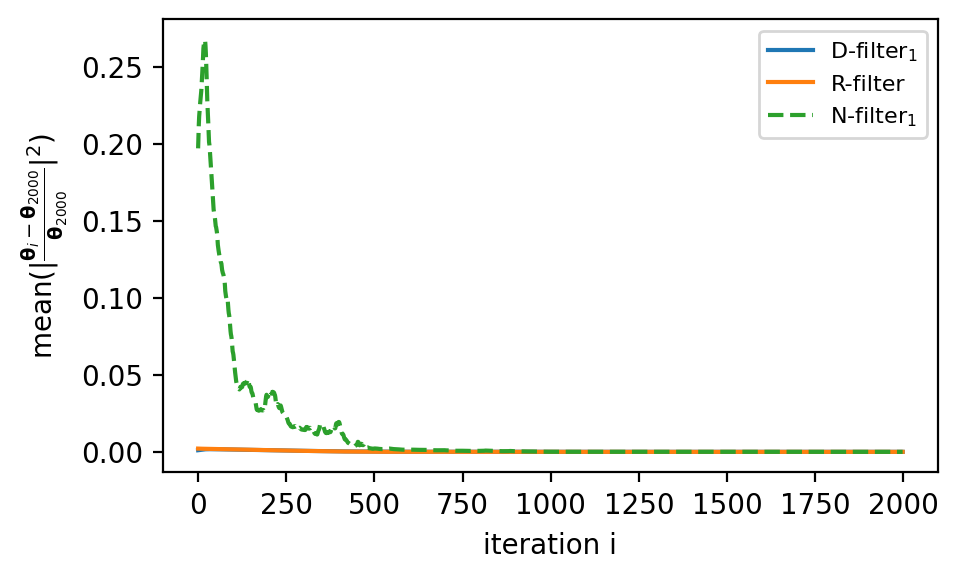

In [7]:
plt.figure(figsize=(5, 3), dpi=200)
sli = slice(0, 2000)
ax1 = plt.gca()
ax1.plot(params_diff['fdbp_0']['DConv_0']['kernel'][sli], label=r'D-filter$_1$')
# ax1.plot(params_diff['fdbp_0']['DConv_1']['kernel'][sli], label=r'D-filter$_2$')
# ax1.plot(params_diff['fdbp_0']['DConv_2']['kernel'][sli], label=r'D-filter$_3$')
ax1.plot(params_diff['RConv']['kernel'][sli], label=r'R-filter')
ax1.plot(params_diff['fdbp_0']['NConv_0']['kernel'][sli], '--', label=r'N-filter$_1$', markersize=1)
# ax1.plot(params_diff['fdbp_0']['NConv_1']['kernel'][sli], '--', label=r'N-filter$_2$', markersize=1)
# ax1.plot(params_diff['fdbp_0']['NConv_2']['kernel'][sli], '--', label=r'N-filter$_3$', markersize=1)
ax1.legend(fontsize=8, loc='lower left')
ax1.set_ylabel(r'mean(|$\frac{\mathbf{\theta}_i - \mathbf{\theta}_{2000}}{\mathbf{\theta}_{2000}}|^2$)')
ax1.set_xlabel('iteration i')

# ax2 = ax1.twinx()
# ax1.plot(state_diff['af_state']['mimoaf_0']['mimoaf'][1][0][sli], color='black', label='MIMO(w)')
ax1.legend(fontsize=8)

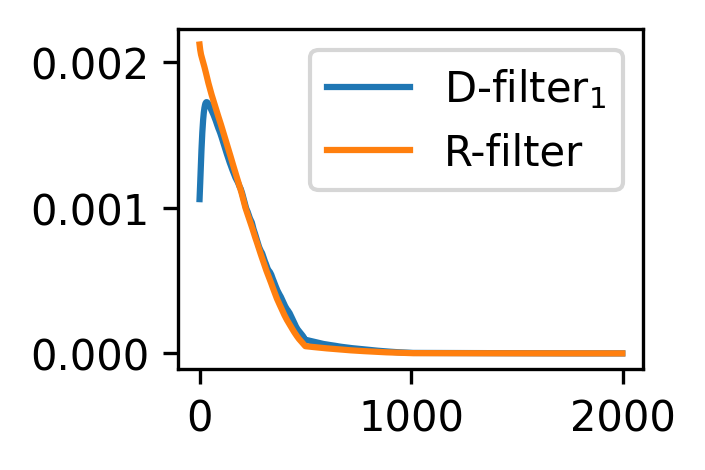

In [73]:
plt.figure(figsize=(2, 1.5), dpi=300)
sli = slice(0, 2000)
ax1 = plt.gca()
ax1.plot(params_diff['fdbp_0']['DConv_0']['kernel'][sli], label=r'D-filter$_1$')
ax1.plot(params_diff['RConv']['kernel'][sli], label=r'R-filter')
plt.legend()

In [78]:
importlib.reload(gplt)

<module 'src.plot' from '/home/remi/Workspace/commplax_train/src/plot.py'>

(0.023, 0.045)

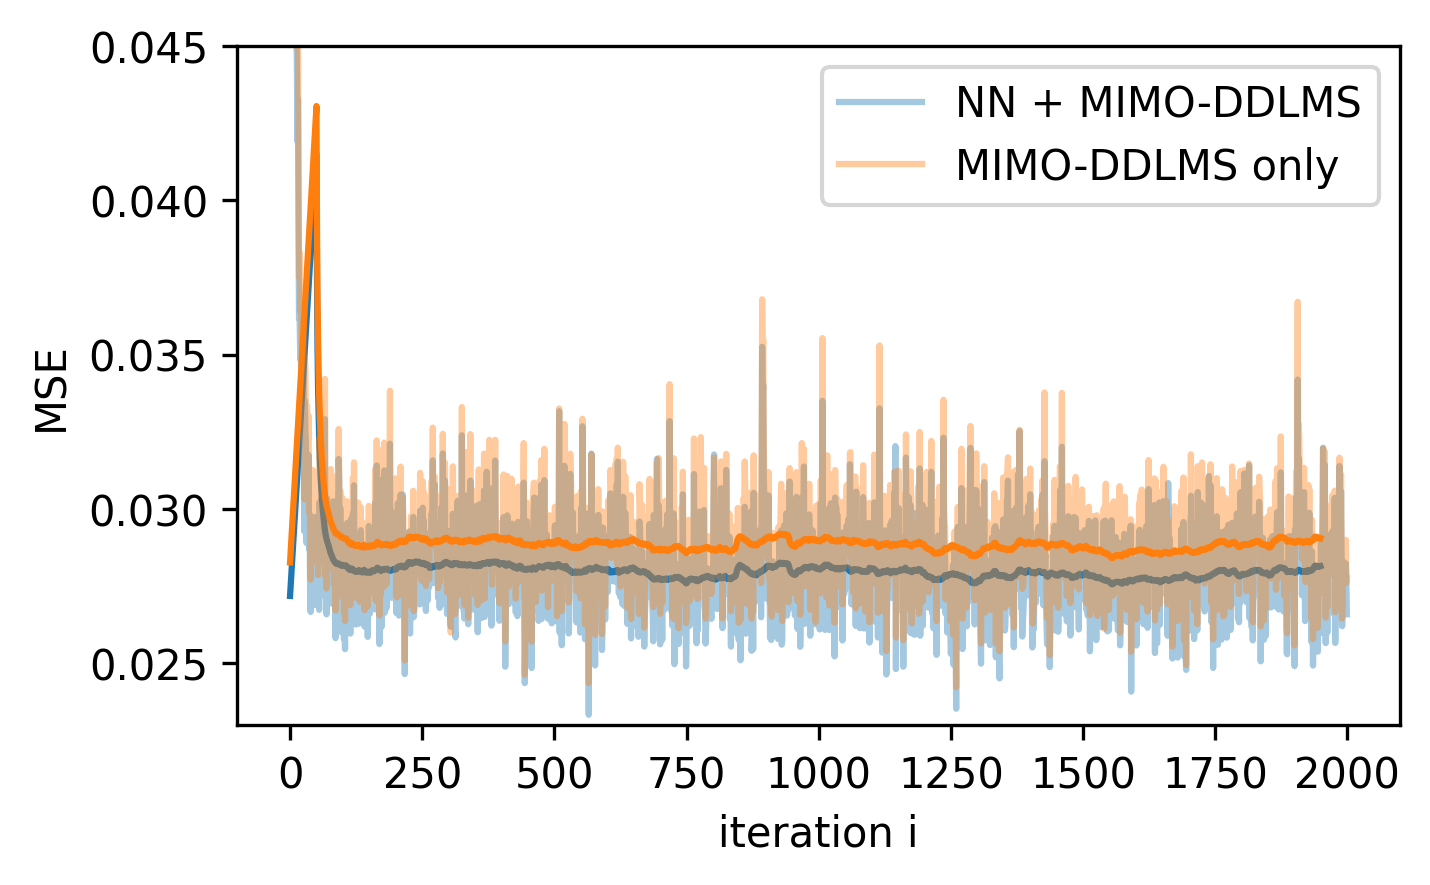

In [86]:
plt.figure(figsize=(5, 3), dpi=300)
ax = plt.gca()
gplt.loss(loss_gdbp, ax=ax, label='NN + MIMO-DDLMS')
gplt.loss(loss_fdbp, ax=ax, label='MIMO-DDLMS only')
ax.set_xlabel('iteration i')
ax.set_ylim([0.023, 0.045])

In [87]:
# c = plt.cm.RdPu_r(np.linspace(0, 0.8, 6))
# fig, axs = plt.subplots(2, 2, figsize=(9, 9), dpi=200)

# for i, n in enumerate([0, 100000, 200000, 500000, 1000000, 2000000]):
#   axs[0, 0].plot(abs(mimo_w[n, 0, 0, :]), color=c[i], label='%dth symbol' % n)
#   axs[0, 1].plot(abs(mimo_w[n, 0, 1, :]), color=c[i], label='%dth symbol' % n)
#   axs[1, 0].plot(abs(mimo_w[n, 1, 0, :]), color=c[i], label='%dth symbol' % n)
#   axs[1, 1].plot(abs(mimo_w[n, 1, 1, :]), color=c[i], label='%dth symbol' % n)
# axs[0, 0].legend()
# axs[0, 1].legend()
# axs[1, 0].legend()
# axs[1, 1].legend()
# plt.tight_layout()

In [3]:
z, mimo_w = eq.modulusmimo(eq.cdcomp(data.y, data.a['samplerate'], 18.451) * data.f)[:2]
# z, phi = eq.ekfcpr(z)
# w_amp = np.max(np.abs(mimo_w), axis=-1)

Text(0, 0.5, 'max($\\mathbf{|w|}$)')

/home/remi/Applications/miniconda3/envs/commplax_py38_jax0_2_13_jaxlib0_1_66/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


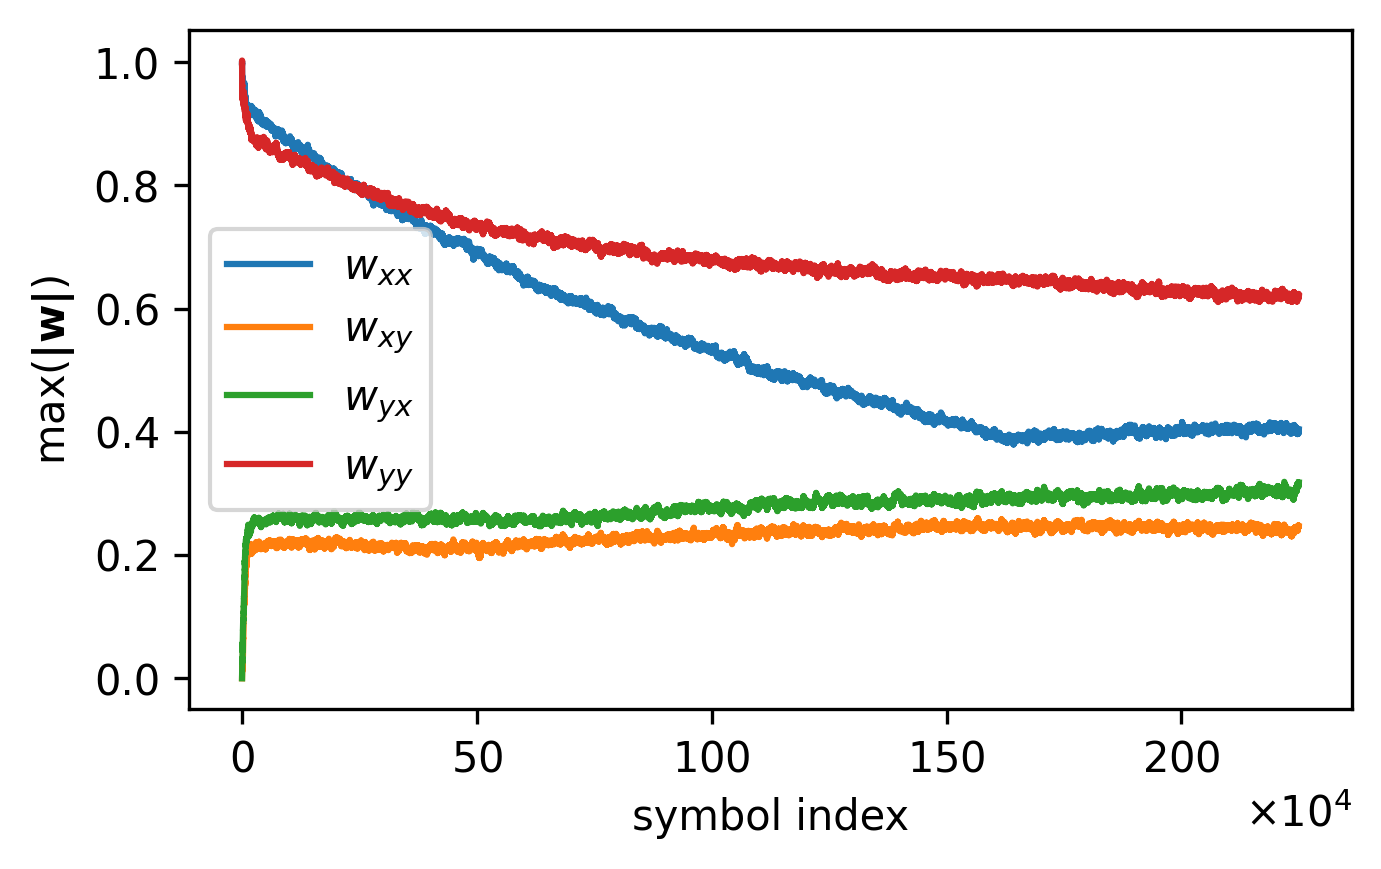

In [43]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(w_amp[:, 0, 0], label=r'$w_{xx}$')
plt.plot(w_amp[:, 0, 1], label=r'$w_{xy}$')
plt.plot(w_amp[:, 1, 0], label=r'$w_{yx}$')
plt.plot(w_amp[:, 1, 1], label=r'$w_{yy}$')
plt.legend()

plt.ticklabel_format(axis='x', scilimits=(4, 4), useMathText=True)
plt.xlabel('symbol index')
plt.ylabel(r'max($\mathbf{|w|}$)')

([<matplotlib.axis.XTick at 0x7f61e54603a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

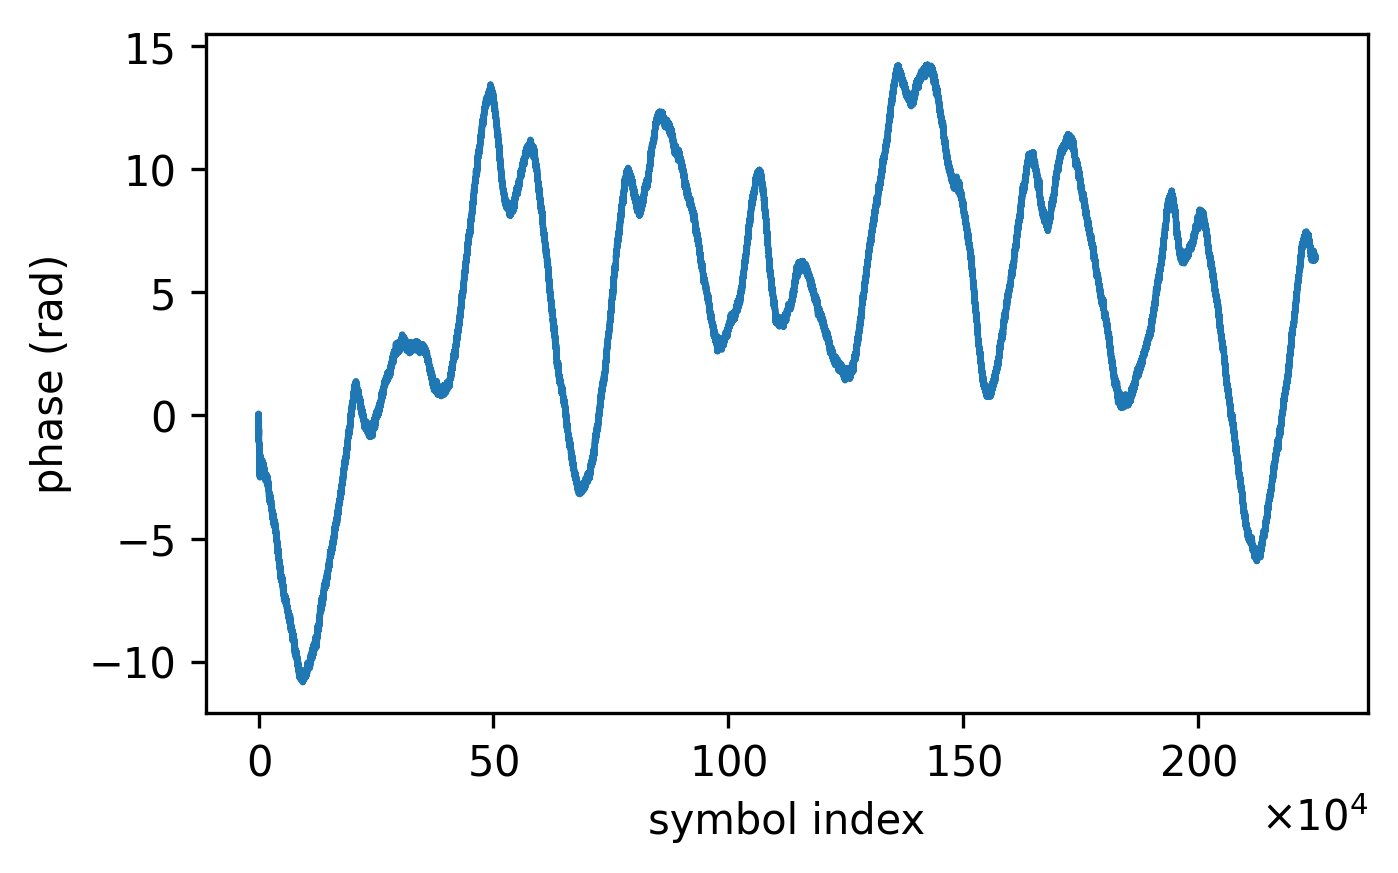

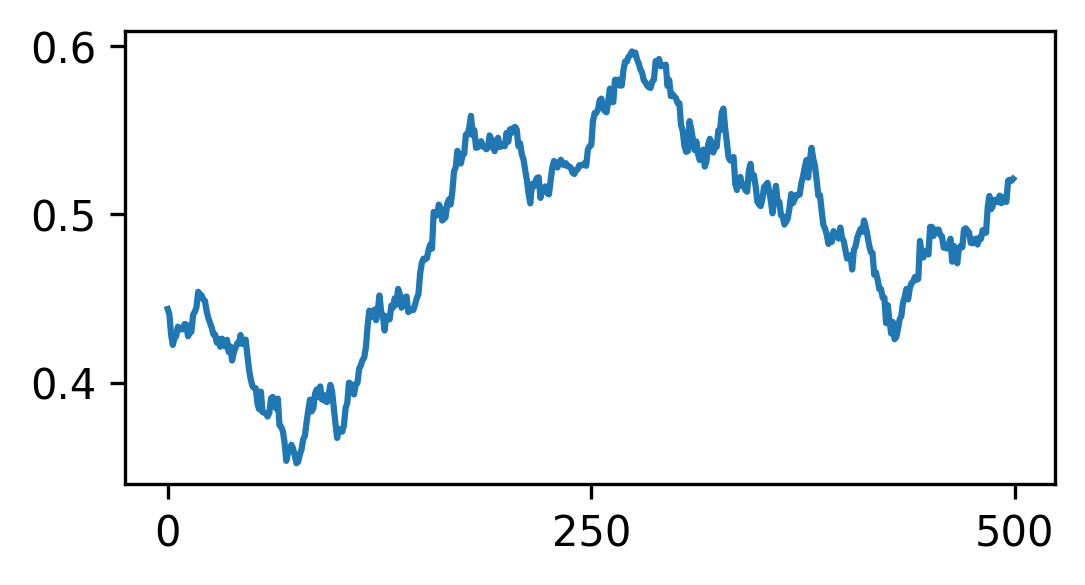

In [40]:
plt.figure(figsize=(5, 3), dpi=300)
ax = plt.gca()
ax.plot(phi.real[:,0])
ax.set_xlabel('symbol index')
ax.set_ylabel('phase (rad)')
plt.ticklabel_format(axis='x', scilimits=(4, 4), useMathText=True)
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(phi[200000:200500, 0].real)
locs, labels = plt.xticks()
plt.xticks([0, 250, 500])